In [1]:
"""Identifying Outliers

    Task: Identify players who had unusually high or low performance in any season.
    Steps:
        Use statistical methods to detect outliers in performance metrics (e.g., points per game, assists).
        Investigate the context around these outliers (e.g., injuries, trades) to understand the reasons behind the anomalies."""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler
from scipy.stats import zscore

sns.set()

## Load the data

In [2]:
raw_data = pd.read_csv("../NBA/nba.csv") 

raw_data.rename(columns={"year": "SEASON", "Season_type": "SEASON_TYPE"}, inplace=True)

raw_data[raw_data["PLAYER"]== "LeBron James" ] 

,SEASON,SEASON_TYPE,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
2,2012-13,Regular%20Season,2544,3,LeBron James,1610612748,MIA,76,2877,765,...,610,551,129,67,226,110,2036,2446,2.44,0.57
468,2012-13,Playoffs,2544,1,LeBron James,1610612748,MIA,23,960,212,...,193,152,41,18,70,43,596,671,2.17,0.59
679,2013-14,Regular%20Season,2544,3,LeBron James,1610612748,MIA,77,2902,767,...,533,488,121,26,270,126,2089,2255,1.81,0.45
1160,2013-14,Playoffs,2544,2,LeBron James,1610612748,MIA,20,763,192,...,141,95,36,11,61,46,548,591,1.56,0.59
1365,2014-15,Regular%20Season,2544,4,LeBron James,1610612739,CLE,69,2493,624,...,416,511,109,49,272,135,1743,1748,1.88,0.40
1854,2014-15,Playoffs,2544,1,LeBron James,1610612739,CLE,20,844,227,...,226,169,33,21,82,58,601,606,2.06,0.40
2065,2015-16,Regular%20Season,2544,4,LeBron James,1610612739,CLE,76,2709,737,...,565,514,104,49,249,143,1920,2092,2.06,0.42
2539,2015-16,Playoffs,2544,2,LeBron James,1610612739,CLE,21,822,219,...,200,160,49,27,75,54,552,673,2.13,0.65
2761,2016-17,Regular%20Season,2544,9,LeBron James,1610612739,CLE,74,2795,736,...,639,646,92,44,303,134,1954,2291,2.13,0.30
3239,2016-17,Playoffs,2544,1,LeBron James,1610612739,CLE,18,744,217,...,164,141,35,23,72,43,591,666,1.96,0.49


### Identify performance metrics

In [3]:
p_metrics = raw_data[["PTS", "AST",  "REB", "STL", "BLK"]]
p_metrics

,PTS,AST,REB,STL,BLK
0,2280,374,640,116,105
1,2133,469,433,106,25
2,2036,551,610,129,67
3,2023,455,379,142,38
4,1920,171,460,52,32
...,...,...,...,...,...
8830,0,1,3,0,0
8831,0,1,1,0,0
8832,0,1,3,0,0
8833,0,0,0,0,0


#### Calculate basic stats

In [ ]:
p_metrics.mean()

### Check distribution

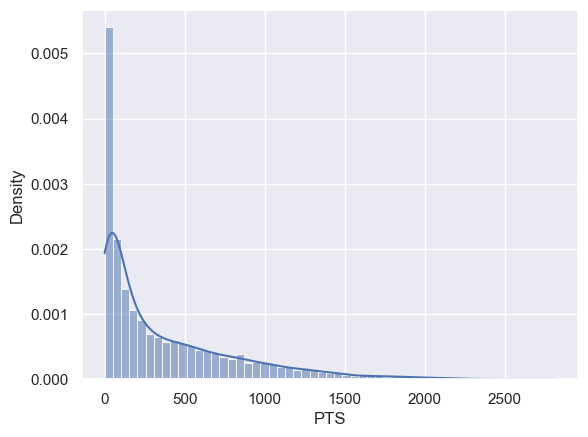

In [5]:
# Check distributions
sns.histplot(p_metrics["PTS"], kde=True, stat="density")
plt.show()

In [6]:
cols_to_scale = [col for col in p_metrics]
scaled_cols = [f"{col}_Z" for col in p_metrics]

### Identify outliers

In [7]:
# Check for NaNs and drop rows with NaNs in the specified columns
p_metrics = p_metrics.dropna(subset=cols_to_scale)

# Apply zscore to the selected columns, handling NaN values and zero standard deviation
scaled_values = p_metrics[cols_to_scale].apply(lambda x: zscore(x) if x.std() != 0 else x)

# Rename the columns of the scaled_values DataFrame
scaled_values.columns = scaled_cols

p_metrics.loc[:, scaled_cols] = scaled_values

# Define a threshold for outliers. How many standard deviations away from the mean a data point must be to be considered an outlier.
threshold = 3

outliers = p_metrics[(p_metrics["PTS_Z"].abs() > threshold) | (p_metrics["AST_Z"].abs() > threshold) 
    | (p_metrics["REB_Z"].abs() > threshold) | (p_metrics["STL_Z"].abs() > threshold) | (p_metrics["BLK_Z"].abs() > threshold)]
outliers.describe()

,PTS,AST,REB,STL,BLK,PTS_Z,AST_Z,REB_Z,STL_Z,BLK_Z
count,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,1263.486486,307.960254,518.742448,81.497615,67.678855,2.032575,1.950695,2.065448,1.836382,1.975895
std,480.228547,203.037789,230.453666,36.508642,51.425587,1.097810,1.756382,1.299938,1.221224,2.004051
min,304.000000,6.000000,149.000000,16.000000,3.000000,-0.160825,-0.661419,-0.020187,-0.354531,-0.544635
25%,887.000000,116.000000,323.000000,53.000000,25.000000,1.171921,0.290139,0.961308,0.883129,0.312703
50%,1204.000000,278.000000,481.000000,75.000000,51.000000,1.896588,1.691523,1.852551,1.619035,1.325921
75%,1652.000000,470.000000,702.000000,109.000000,103.000000,2.920723,3.352423,3.099164,2.756344,3.352358
max,2818.000000,907.000000,1247.000000,191.000000,269.000000,5.586216,7.132700,6.173388,5.499266,9.821366


In [8]:
# Using IQR 
Q1 = p_metrics[cols_to_scale].quantile(0.05) 
Q2 = p_metrics[cols_to_scale].quantile(0.95)

IQR = Q2 - Q1 

# the outlier threshold helps determine which data points are considered outliers based on their distance from the first quantile (Q1) and second quantile (Q2) of the dataset.
iqr_threshold = 1.5

iqr_outliers = p_metrics[((p_metrics[cols_to_scale] < (Q1 - iqr_threshold * IQR)) | (p_metrics[cols_to_scale] > (Q2 + iqr_threshold * IQR))).any(axis=1)]

### Get per game metrics for players

In [16]:
p_metrics["GP"] = raw_data["GP"]
# p_metrics["PPG"] = p_metrics["PTS"] / p_metrics["GP"]
p_metrics["PLAYER"] = raw_data["PLAYER"]
p_metrics["SEASON"] = raw_data["SEASON"]
p_metrics["TEAM"] = raw_data["TEAM"]
p_metrics["PLAYER_ID"] = raw_data["PLAYER_ID"]

grouped_metrics = p_metrics.groupby(["PLAYER_ID", "PLAYER", "SEASON", "TEAM"]).agg({"PTS": "sum", "GP": "sum", "AST": "sum", "REB": "sum", "STL": "sum", "BLK": "sum"}).reset_index()
grouped_metrics["PPG"] = grouped_metrics["PTS"] / grouped_metrics["GP"]
grouped_metrics["APG"] = grouped_metrics["AST"] / grouped_metrics["GP"]
grouped_metrics["RPG"] = grouped_metrics["REB"] / grouped_metrics["GP"]
grouped_metrics["SPG"] = grouped_metrics["STL"] / grouped_metrics["GP"]
grouped_metrics["BPG"] = grouped_metrics["BLK"] / grouped_metrics["GP"]

grouped_metrics = grouped_metrics[(grouped_metrics['PPG'] != 0) & (grouped_metrics['APG'] != 0) & (grouped_metrics['RPG'] != 0) & (grouped_metrics['SPG'] != 0) 
    & (grouped_metrics['BPG'] != 0)].reset_index(drop=True)

lebron_df = grouped_metrics[grouped_metrics["PLAYER"] == "LeBron James"].copy().reset_index(drop=True)
lebron_df

,PLAYER_ID,PLAYER,SEASON,TEAM,PTS,GP,AST,REB,STL,BLK,PPG,APG,RPG,SPG,BPG
0,2544,LeBron James,2012-13,MIA,2632,99,703,803,170,85,26.585859,7.101010,8.111111,1.717172,0.858586
1,2544,LeBron James,2013-14,MIA,2637,97,583,674,157,37,27.185567,6.010309,6.948454,1.618557,0.381443
2,2544,LeBron James,2014-15,CLE,2344,89,680,642,142,70,26.337079,7.640449,7.213483,1.595506,0.786517
3,2544,LeBron James,2015-16,CLE,2472,97,674,765,153,76,25.484536,6.948454,7.886598,1.577320,0.783505
4,2544,LeBron James,2016-17,CLE,2545,92,787,803,127,67,27.663043,8.554348,8.728261,1.380435,0.728261
5,2544,LeBron James,2017-18,CLE,2999,104,945,909,146,94,28.836538,9.086538,8.740385,1.403846,0.903846
6,2544,LeBron James,2018-19,LAL,1505,55,454,465,72,33,27.363636,8.254545,8.454545,1.309091,0.600000
7,2544,LeBron James,2019-20,LAL,2278,88,868,751,104,54,25.886364,9.863636,8.534091,1.181818,0.613636
8,2544,LeBron James,2020-21,LAL,1266,51,398,389,57,27,24.823529,7.803922,7.627451,1.117647,0.529412
9,2544,LeBron James,2021-22,LAL,1695,56,349,459,73,59,30.267857,6.232143,8.196429,1.303571,1.053571
